In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule
from rdkit.Chem.rdchem import RWMol
from rdkit.Chem import Draw, rdMolAlign, rdDistGeom, AllChem
from tooltoad.vis import MolTo3DGrid

from frust.utils.mols import combine_rw_mols, remove_one_h, get_molecule_name
from frust.transformers import transformer_mols
from frust.embedder import embed_mols

In [ ]:
mols_dict = transformer_mols(only_uniques=False)
mols = [x for x in mols_dict.values()]
legends = [x for x in mols_dict.keys()]

num_confs = 10
num_threads = 5
optimization = 'UFF'
max_iters = 100

mols_dict_embedded = {}
for name, mol in mols_dict.items():
    mol = Chem.AddHs(mol)
    cids = rdDistGeom.EmbedMultipleConfs(
        mol=mol,
        randomSeed=0xF00D,
        numConfs=num_confs,
        numThreads=num_threads,
    )

    opt_method = optimization.strip()
    if opt_method.upper() == 'MMFF94' or opt_method.upper() == 'MMFF94S':
        mmff_variant = 'MMFF94' if opt_method.upper() == 'MMFF94' else 'MMFF94s'
        for conf_id in range(mol.GetNumConformers()):
            props = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant=mmff_variant)
            if props is not None:
                AllChem.MMFFOptimizeMolecule(mol, mmffVariant=mmff_variant,
                                             confId=conf_id, maxIters=max_iters)
    elif opt_method.upper() == 'UFF' and name != 'dimer':
        for conf_id in range(mol.GetNumConformers()):
            AllChem.UFFOptimizeMolecule(mol, confId=conf_id, maxIters=max_iters)

    mols_dict_embedded[name] = (mol, list(cids))

mols_dict_embedded

{'dimer': (<rdkit.Chem.rdchem.Mol at 0x31556b680>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'N,N-dihexyl-2-(trifluoromethyl)benzamide': (<rdkit.Chem.rdchem.Mol at 0x31556b3e0>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'catalyst': (<rdkit.Chem.rdchem.Mol at 0x31556b4c0>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'int2_rpos(33)': (<rdkit.Chem.rdchem.Mol at 0x31556b5a0>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'int2_rpos(34)': (<rdkit.Chem.rdchem.Mol at 0x31556b530>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'int2_rpos(35)': (<rdkit.Chem.rdchem.Mol at 0x31556b060>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'int2_rpos(36)': (<rdkit.Chem.rdchem.Mol at 0x31556aff0>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'mol2_rpos(33)': (<rdkit.Chem.rdchem.Mol at 0x31556af80>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'mol2_rpos(34)': (<rdkit.Chem.rdchem.Mol at 0x31556af10>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'mol2_rpos(35)': (<rdkit.Chem.rdchem.Mol at 0x31556aea0>,
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'mol2_rpos(36)': (<rdkit.Chem.rdchem.Mol at 0

In [27]:
mols_dict = transformer_mols(only_uniques=False, only_generics=True)
mols_dict_embedded = embed_mols(mols_dict, 1)
mols_dict_embedded

{'dimer': (<rdkit.Chem.rdchem.Mol at 0x3175b69d0>, [0]),
 'N,N-dihexyl-2-(trifluoromethyl)benzamide': (<rdkit.Chem.rdchem.Mol at 0x3175b6810>,
  [0]),
 'catalyst': (<rdkit.Chem.rdchem.Mol at 0x3175b4c80>, [0]),
 'HBpin-mol': (<rdkit.Chem.rdchem.Mol at 0x3175b7e60>, [0])}

In [ ]:
from frust.stepper import Stepper
step = Stepper(["CCCCCCN(CCCCCC)C(=O)c1ccccc1C(F)(F)F"], save_output_dir=False, n_cores=2)

df0 = step.build_initial_df(mols_dict_embedded)
df0

,custom_name,ligand_name,rpos,constraint_atoms,cid,smiles,atoms,coords_embedded,energy_uff
0,dimer,dimer,<NA>,None,0,None,"[C, C, C, C, C, C, C, C, C, N, C, C, C, C, C, ...","[(4.11879519449192, 1.9053088921085697, 1.6525...",None
1,"N,N-dihexyl-2-(trifluoromethyl)benzamide","N,N-dihexyl-2-(trifluoromethyl)benzamide",<NA>,None,0,None,"[C, C, C, C, C, C, N, C, C, C, C, C, C, C, O, ...","[(-2.5759841842331492, -3.777074991396932, -2....",None
2,catalyst,catalyst,<NA>,None,0,None,"[C, C, C, C, C, C, C, C, C, N, C, C, C, C, C, ...","[(-0.0469664474082614, -2.4804594294798843, 0....",None
3,HBpin-mol,HBpin-mol,<NA>,None,0,None,"[C, C, C, O, B, O, C, C, C, H, H, H, H, H, H, ...","[(1.4638068161759974, 1.0578481687265948, 0.12...",None


In [41]:
df1 = step.xtb(df0.iloc[1:2], options={"gfn": 1})

In [42]:
df2 = step.xtb(df1, options={"gfn": 2, "opt": None})

In [44]:
df2

,custom_name,ligand_name,rpos,constraint_atoms,cid,smiles,atoms,coords_embedded,energy_uff,xtb-gfn-electronic_energy,xtb-gfn-normal_termination,xtb-gfn-opt-electronic_energy,xtb-gfn-opt-normal_termination,xtb-gfn-opt-opt_coords
1,"N,N-dihexyl-2-(trifluoromethyl)benzamide","N,N-dihexyl-2-(trifluoromethyl)benzamide",<NA>,None,0,None,"[C, C, C, C, C, C, N, C, C, C, C, C, C, C, O, ...","[(-2.5759841842331492, -3.777074991396932, -2....",None,-81.800708,True,-79.366523,True,"[[-3.08161686219479, -3.40474884555935, -3.002..."


In [ ]:
ligand_smiles = "CCCCCCN(CCCCCC)C(=O)c1ccccc1C(F)(F)F"
catalyst_smiles = "CC1(C)CCCC(C)(C)N1C2=CC=CC=C2B"
only_uniques = False
show_IUPAC=True

In [170]:
catalyst_mol = Chem.MolFromSmiles(catalyst_smiles)
ligand_mol   = Chem.MolFromSmiles(ligand_smiles)

catalyst_rw = RWMol(catalyst_mol)
ligand_rw   = RWMol(ligand_mol)

####################
### Create dimer ###
####################
catalyst1 = Chem.MolFromSmiles(catalyst_smiles)
catalyst2 = Chem.MolFromSmiles(catalyst_smiles)

B_pattern_dimer = Chem.MolFromSmarts("[B]c1ccccc1")
B_match_dimer = catalyst1.GetSubstructMatches(B_pattern_dimer)

B_idx_1 = B_match_dimer[0][0]
catalyst1 = Chem.AddHs(catalyst1, onlyOnAtoms=[B_idx_1])
catalyst2 = Chem.AddHs(catalyst2, onlyOnAtoms=[B_idx_1])

catalyst1_RW = RWMol(catalyst1)
catalyst2_RW = RWMol(catalyst2)

dimer, offset = combine_rw_mols(catalyst1_RW, catalyst2_RW)

BHH_pattern = Chem.MolFromSmarts("B([H])([H])c1ccccc1")
BHH_match = catalyst1.GetSubstructMatches(BHH_pattern)

cat1_H1_idx = BHH_match[0][1]
cat1_H2_idx = BHH_match[0][2]
cat2_H1_idx = cat1_H1_idx + offset
cat2_H2_idx = cat1_H2_idx + offset

cat1_B_idx = BHH_match[0][0]
cat2_B_idx = cat1_B_idx + offset

dimer.AddBond(cat1_H1_idx, cat2_B_idx, Chem.BondType.SINGLE)
dimer.AddBond(cat2_H1_idx, cat1_B_idx, Chem.BondType.SINGLE)

cat1_B = dimer.GetAtomWithIdx(cat1_B_idx)
cat2_B = dimer.GetAtomWithIdx(cat2_B_idx)
cat1_B.SetFormalCharge(-1)
cat2_B.SetFormalCharge(-1)

cat1_H1 = dimer.GetAtomWithIdx(cat1_H1_idx)
cat2_H1 = dimer.GetAtomWithIdx(cat2_H1_idx)
cat1_H1.SetFormalCharge(+1)
cat2_H1.SetFormalCharge(+1)

dimer_mol = dimer.GetMol()
Chem.SanitizeMol(dimer_mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

(16, 17, 18, 19)


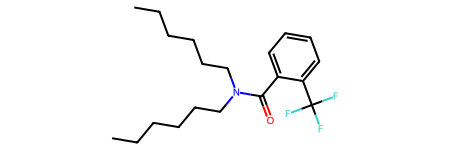

In [171]:
cH_patt = Chem.MolFromSmarts('[cH]')
matches = ligand_rw.GetSubstructMatches(cH_patt)
cH_atoms = [ind[0] for ind in matches]

atom_rank = list(Chem.CanonicalRankAtoms(ligand_rw,breakTies=False))

def find_unique_atoms(lst):
    seen = set()
    result = []
    for i, x in enumerate(lst):
        if x not in seen:
            result.append(i)
            seen.add(x)
    return result

unique_atoms = find_unique_atoms(atom_rank)
unique_cH = set(unique_atoms).intersection(set(cH_atoms))
unique_cH = tuple(unique_cH)

print(unique_cH)
ligand_mol

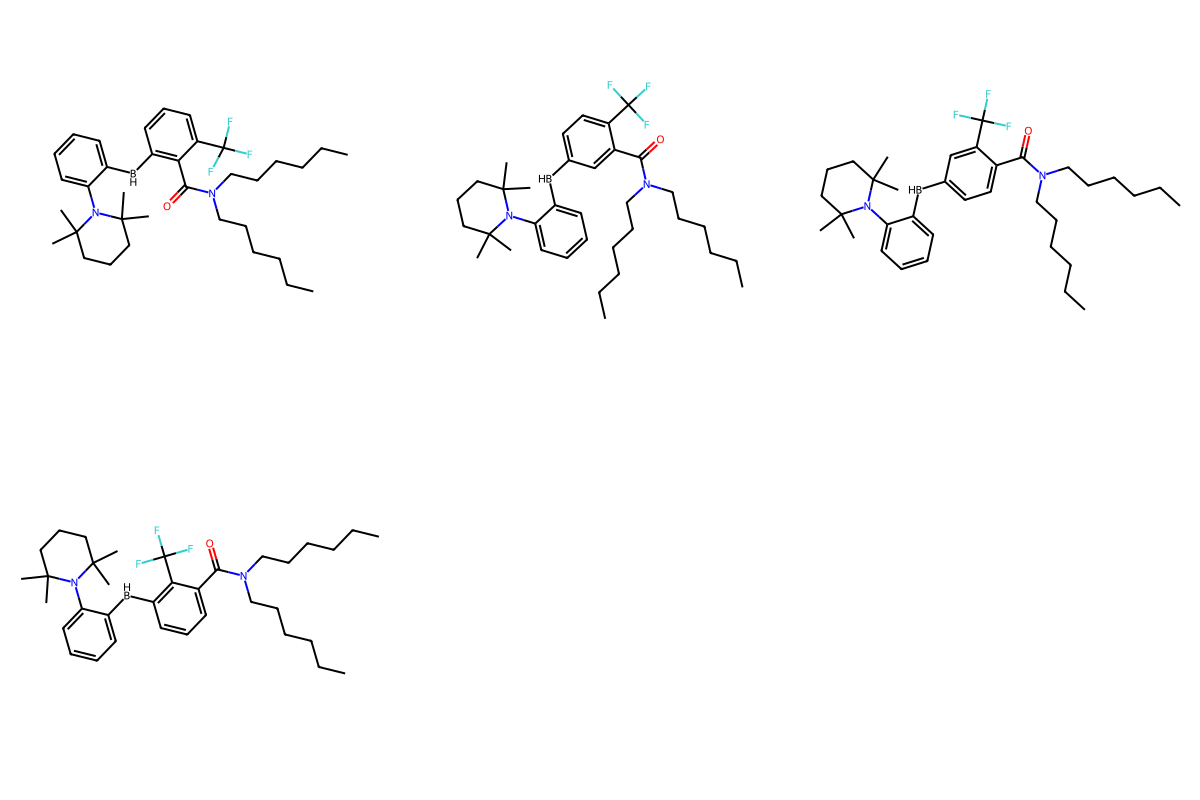

In [172]:
############################################
### Create intermediate 2 and molecule 2 ###
############################################
b_pattern = Chem.MolFromSmarts("[B]")
pyrrole_attach_pattern = Chem.MolFromSmarts("[n,s,o]1[cH][c][c][c]1")

catalyst_matches = catalyst_mol.GetSubstructMatches(b_pattern)

if not catalyst_matches:
    raise ValueError("No [B] atom found in the catalyst.")

catalyst_b_idx = catalyst_matches[0][0]

# print("Catalyst: B is at atom idx =", catalyst_b_idx)

mol2s = []
int2s = []
for cH in unique_cH:

    combined_rw, offset = combine_rw_mols(catalyst_rw, ligand_rw)
    combined_mol = combined_rw.GetMol()
    Chem.SanitizeMol(combined_mol)
    
    b_idx_combined   = catalyst_b_idx
    ch_idx_combined  = cH + offset

    combined_rw.AddBond(b_idx_combined, ch_idx_combined, Chem.BondType.SINGLE)

    mol2 = combined_rw.GetMol()

    boron = combined_rw.GetAtomWithIdx(catalyst_b_idx)
    boron.SetFormalCharge(-1)

    TMP = Chem.MolFromSmarts('CC1(C)CCCC(C)(C)N1')
    TMP_match = combined_rw.GetSubstructMatches(TMP)
    nitrogen = combined_rw.GetAtomWithIdx(TMP_match[0][9])
    nitrogen.SetFormalCharge(+1)

    int2 = combined_rw.GetMol()
    Chem.SanitizeMol(mol2)
    Chem.SanitizeMol(int2)

    mol2s.append((mol2, ch_idx_combined))
    int2s.append((int2, ch_idx_combined))

mols = [x[0] for x in mol2s]

Draw.MolsToGridImage(mols, subImgSize=(400,400))

In [173]:
###########################
### Add HBpin to ligand ###
###########################
HBpin_smile = 'CC1(C)OB([H])OC1(C)C'
HBpin_mol = Chem.MolFromSmiles(HBpin_smile)
HBpin_with_hs = Chem.AddHs(HBpin_mol)
HBpin_rw      = RWMol(HBpin_with_hs)
HBpin_b_idx   = HBpin_rw.GetSubstructMatches(b_pattern)[0][0]

remove_one_h(HBpin_rw, HBpin_b_idx)

HBpin_ligands = []
for cH in unique_cH:
    combined_HBpin, offset = combine_rw_mols(HBpin_rw, ligand_rw)

    b_idx_combined_HBpin = HBpin_b_idx
    ch_idx_combined = cH + offset

    combined_HBpin.AddBond(b_idx_combined_HBpin, ch_idx_combined, Chem.BondType.SINGLE)
    HBpin_ligand = Chem.RemoveHs(combined_HBpin)

    HBpin_ligands.append((HBpin_ligand, ch_idx_combined))

In [179]:
#######################
### Finalize output ###
#######################
names = ['dimer', 'ligand', 'catalyst', 'int2', 'mol2', 'HBpin-ligand', 'HBpin-mol']
if show_IUPAC: 
    name = get_molecule_name(ligand_smiles)
    names[1] = name

mols = [dimer, ligand_mol, catalyst_mol, int2s, mol2s, HBpin_ligands, HBpin_mol]
mols_dict = {}
for name, mol in zip(names, mols):
    if name in ['int2', 'mol2', 'HBpin-ligand']:
        for m, i in mol:
            n = name + f"_rpos({str(i)})"
            mols_dict[n] = m
    elif not only_uniques:
        mols_dict[name] = m

In [180]:
mols_dict

{'dimer': <rdkit.Chem.rdchem.Mol at 0x147e81770>,
 'N,N-dihexyl-2-(trifluoromethyl)benzamide': <rdkit.Chem.rdchem.Mol at 0x147e81770>,
 'catalyst': <rdkit.Chem.rdchem.Mol at 0x147e81770>,
 'int2_rpos(33)': <rdkit.Chem.rdchem.Mol at 0x147f9bca0>,
 'int2_rpos(34)': <rdkit.Chem.rdchem.Mol at 0x147f9ae30>,
 'int2_rpos(35)': <rdkit.Chem.rdchem.Mol at 0x147f9a420>,
 'int2_rpos(36)': <rdkit.Chem.rdchem.Mol at 0x147f9a500>,
 'mol2_rpos(33)': <rdkit.Chem.rdchem.Mol at 0x1479ffb50>,
 'mol2_rpos(34)': <rdkit.Chem.rdchem.Mol at 0x1479ffa70>,
 'mol2_rpos(35)': <rdkit.Chem.rdchem.Mol at 0x147f9ba00>,
 'mol2_rpos(36)': <rdkit.Chem.rdchem.Mol at 0x147f9a570>,
 'HBpin-ligand_rpos(37)': <rdkit.Chem.rdchem.Mol at 0x14780e180>,
 'HBpin-ligand_rpos(38)': <rdkit.Chem.rdchem.Mol at 0x147a97d80>,
 'HBpin-ligand_rpos(39)': <rdkit.Chem.rdchem.Mol at 0x1479fd8c0>,
 'HBpin-ligand_rpos(40)': <rdkit.Chem.rdchem.Mol at 0x147e81770>,
 'HBpin-mol': <rdkit.Chem.rdchem.Mol at 0x147e81770>}

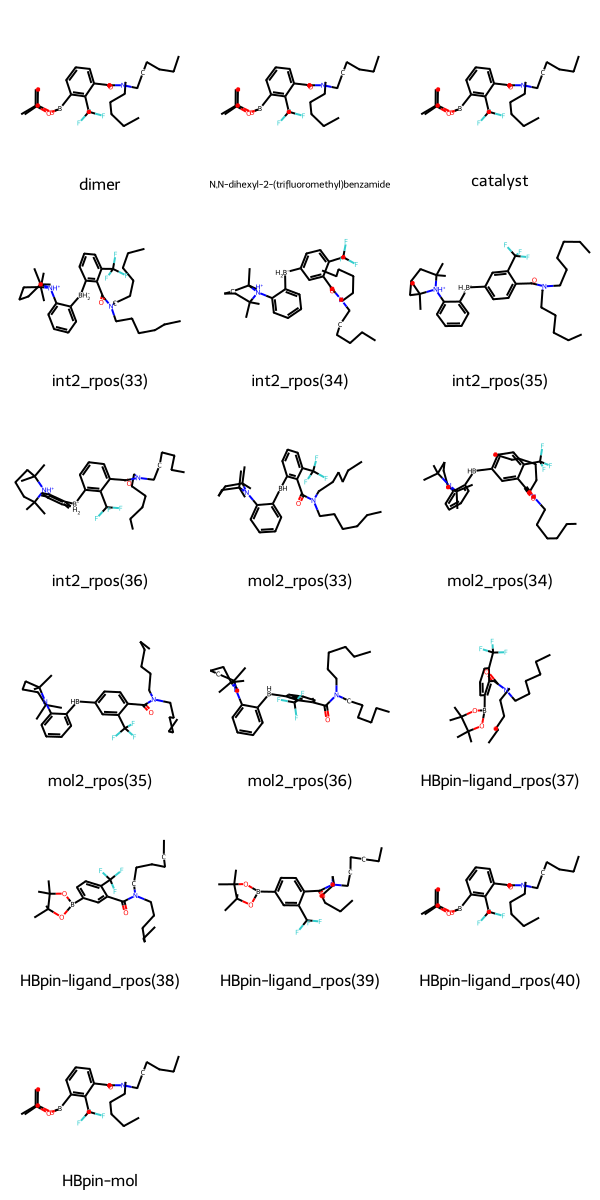

In [183]:
mols = [x for x in mols_dict.values()]
legends = [x for x in mols_dict.keys()]

Draw.MolsToGridImage(mols, legends=legends)

In [182]:
MolTo3DGrid(mols)

[15:48:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:02] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:03] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:03] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:03] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:03] Molecule does not have explicit Hs. Consider calling AddHs()
[15:48:03] Molecule does not have explicit Hs. Consider calling AddHs()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.